# KNN, Decision Tree, SVM and Logistic Regression1
## Evaluations in Jaccard, F1-score and Log Loss with a bit of EDA



# 
# Objective
Predict loan as potentially success or failure, based on "PAIDOFF" vs. "COLLECTION" of past loans.

## Steps
1. Load a dataset using Pandas library with prelimiary analysis and data wrangling, including One Hot Encoding
2. Apply 4 models of K Nearest Neighbor (KNN), Decision Tree (in CART), Support Vector Machine (SVM) and Logistic Regression
3. Evaluate accuracy in Jaccard, F1-score, and Log Loss

## Data

The **Loan.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

 # Load libraries

In [1]:
!conda install -c anaconda seaborn -y
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn import preprocessing

%matplotlib inline

### Get training data 

In [3]:
df = pd.read_csv("loan_train.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


### Sizing up 
Counts of paidoff vs. collection

In [4]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

### A bit of EDA

Age and gender vs. payoff/collection 

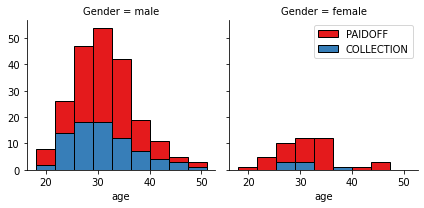

In [5]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

Amount and gender vs. payoff/collection

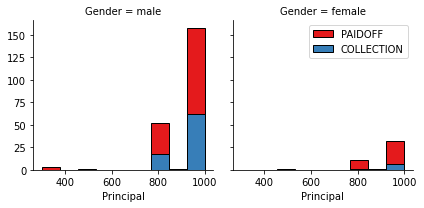

In [6]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

Gender

In [7]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan

# Data cleansing, visualization and pre-processing
### Convert date/time object

In [8]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


### Does the-day-of-the-week matter? 

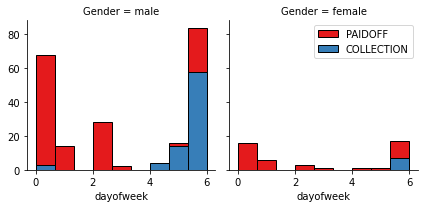

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

### Interesting ... so, people who get the loan at the end of the week, don't pay it off? 

Use feature binarization to set a threshold value less than day 4

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


In [11]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [12]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [13]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append to the Feature dataframe


In [14]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature set and labels


In [15]:
X = Feature
Y = df['loan_status'].values

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [16]:
X= preprocessing.StandardScaler().fit(X).transform(X)
# X[0:5]

# Models
## 0. Train/split of data

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  Y_train.shape)
print ('Test set:', X_test.shape,  Y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


### 1. K Nearest Neighbor (KNN)

Find the best K.

The best K for KNN is 7 with accuracy as 0.7857142857142857


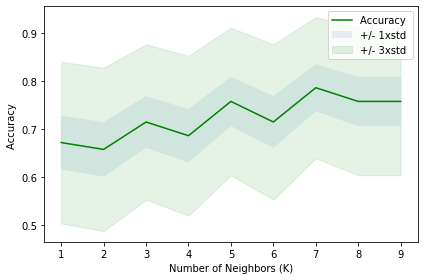

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# loop through Ks to find the best k 

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    # Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,Y_train)
    yhat_knn=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(Y_test, yhat_knn)
    std_acc[n-1]=np.std(yhat_knn==Y_test)/np.sqrt(yhat_knn.shape[0])
    # print("Accuracy for k =", n, "is:", metrics.accuracy_score(Y_test, yhat_knn))

bestK = mean_acc.argmax()+1

print("The best K for KNN is", bestK, "with accuracy as", mean_acc.max())

plt.plot(range(1, Ks),mean_acc,'g')
plt.fill_between(range(1, Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1, Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10, color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

## 2. Decision Tree
Find the best T.

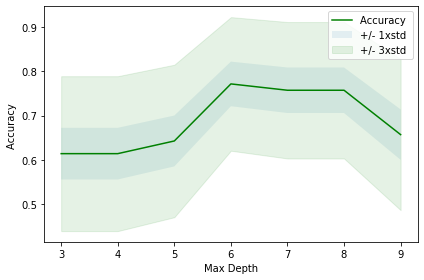

The best decision-tree level is at 6 with accuracy as 0.7714285714285715


In [19]:
from sklearn.tree import DecisionTreeClassifier

Ts = 10
mean_acc = np.zeros((Ts-3))
std_acc = np.zeros((Ts-3))

for n in range(3, Ts):
    trees = DecisionTreeClassifier(criterion="entropy", max_depth=n).fit(X_train, Y_train)
    yhat=trees.predict(X_test)
    mean_acc[n-3]=metrics.accuracy_score(Y_test, yhat)
    std_acc[n-3]=np.std(yhat==Y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(3, Ts),mean_acc,'g')
plt.fill_between(range(3, Ts),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(3, Ts),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Max Depth')
plt.tight_layout()
plt.show()

bestT = mean_acc.argmax()+3

print("The best decision-tree level is at", bestT, "with accuracy as", mean_acc.max())

Just for fun

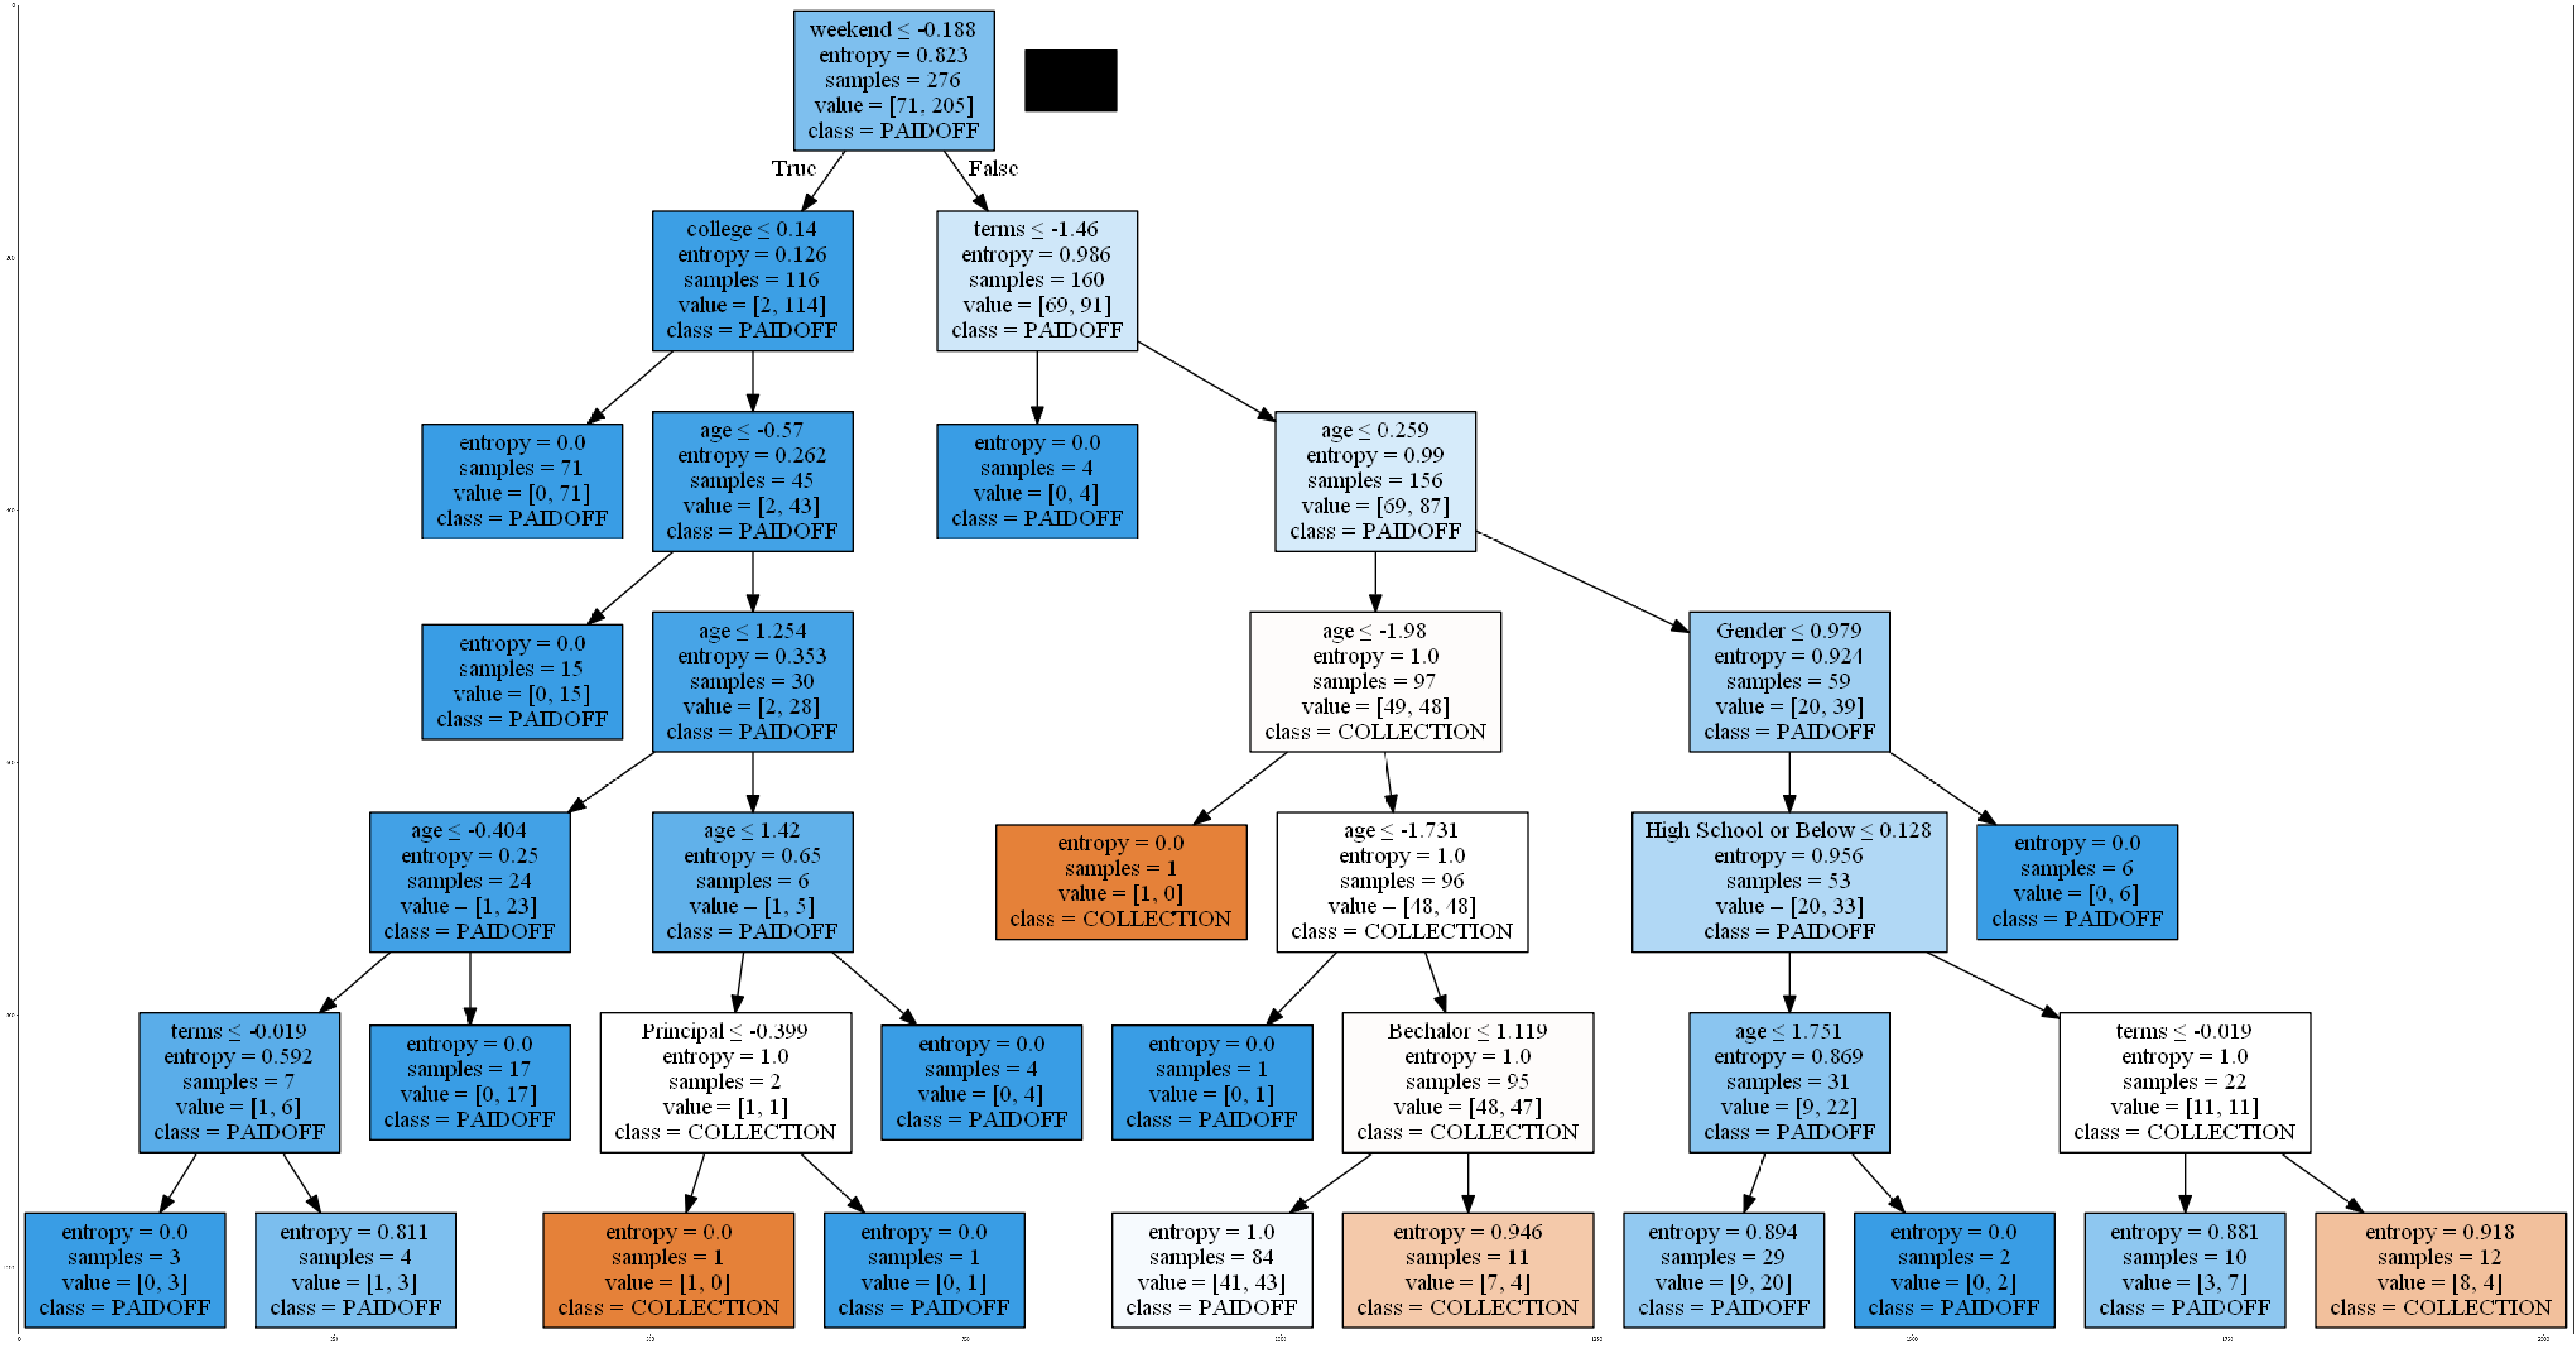

In [20]:
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = bestT)
loanTree.fit(X_train,Y_train)

dot_data = StringIO()
filename = "loantree.png"
featureNames = Feature.columns[0:8]
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(Y_train), filled=True, special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')


## 3. Support Vector Machine


In [21]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, Y_train) 
yhat_svm = clf.predict(X_test)
print("SVM's Accuracy is:", metrics.accuracy_score(Y_test, yhat_svm))

SVM's Accuracy is: 0.7428571428571429


## 4. Logistic Regression


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,Y_train)
yhat_lr = LR.predict(X_test)
print("Logistic regression's accuracy is:", metrics.accuracy_score(Y_test, yhat_lr))

Logistic regression's accuracy is: 0.6857142857142857


# Model Evaluation using Test set


In [23]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Load Test set for evaluation


In [24]:
test_df = pd.read_csv("loan_test.csv")
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [25]:
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['weekend'] = test_df['effective_date'].dt.dayofweek.apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#test_df[['Principal','terms','age','Gender','weekend','education']].head()

test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)
test_feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [26]:
test_X= preprocessing.StandardScaler().fit(test_feature).transform(test_feature)
#test_X[0:5]
test_Y = test_df['loan_status']
#test_Y = test_df['loan_status'].replace({'PAIDOFF' : 0, 'COLLECTION': 1}).values
#test_Y

In [27]:
best_knn = KNeighborsClassifier(n_neighbors = bestK).fit(X,Y)
yhat_knn = best_knn.predict(test_X)
#print("KNN: Jaccard is", jaccard_score(y2_test, yhat_knn,pos_label="PAIDOFF"), "and F1-score is", f1_score(y2_test, yhat_knn,pos_label="PAIDOFF"))

best_tree = DecisionTreeClassifier(criterion="entropy", max_depth = bestT).fit(X,Y)
yhat_tree = best_tree.predict(test_X)
#print("Decision-tree: Jaccard is", jaccard_score(y2_test, yhat_tree, pos_label="PAIDOFF"), "and F1-score is", f1_score(y2_test, yhat_tree, pos_label="PAIDOFF"))

clf2 = svm.SVC(kernel='rbf')
clf2.fit(X,Y) 
yhat_svm2 = clf2.predict(test_X)
#print("SVM: Jaccard is", jaccard_score(y2_test, yhat_svm2, pos_label="PAIDOFF"), "and F1-score is", f1_score(y2_test, yhat_svm2, pos_label="PAIDOFF"))

LR2 = LogisticRegression(C=0.01, solver='liblinear').fit(X,Y)
yhat_lr2 = LR.predict(test_X)

yhat_prob2 = LR2.predict_proba(test_X)
#yhat_prob2
#yhat_lr2
#print("Logistic Regression: Jaccard is", jaccard_score(y2_test, yhat_lr2, pos_label="COLLECTION"), "and F1-score is", f1_score(y2_test, yhat_lr2, pos_label="COLLECTION"), "and log loss is", log_loss(y2_test, yhat_prob2))

yhats = [yhat_knn, yhat_tree, yhat_svm2, yhat_lr2]

In [28]:
accuracies = [[jaccard_score(test_Y, yhats[0], pos_label="PAIDOFF"), f1_score(test_Y, yhats[0], pos_label="PAIDOFF"), 'N/A'], 
              [jaccard_score(test_Y, yhats[1], pos_label="PAIDOFF"), f1_score(test_Y, yhats[1], pos_label="PAIDOFF"), 'N/A'],
              [jaccard_score(test_Y, yhats[2], pos_label="PAIDOFF"), f1_score(test_Y, yhats[2], pos_label="PAIDOFF"), 'N/A'], 
              [jaccard_score(test_Y, yhats[3], pos_label="PAIDOFF"), f1_score(test_Y, yhats[3], pos_label="PAIDOFF"), log_loss(test_Y, yhat_prob2)]]

report = pd.DataFrame(accuracies, index=['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'], columns=['Jaccard', 'F1-score', 'LogLoss'])

# Report

Accuracy of models using different evaluation metrics:

In [29]:
report

,Jaccard,F1-score,LogLoss
KNN,0.700000,0.823529,N/A
Decision Tree,0.725490,0.840909,N/A
SVM,0.722222,0.838710,N/A
Logistic Regression,0.735849,0.847826,0.556608
